# Multisensory training, unisensory testing

## Load Libraries

In [1]:
from lstm_net import *
import torch.nn as nn
import Tmaze_UniToMulti as TMUM
import plotting_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

importlib.reload(pf)

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


## Helper Functions With Device

In [2]:
def ensure_same_device(model, *tensors):
    """Moves all tensors to the same device as the model."""
    device = next(model.parameters()).device
    return [t.to(device) for t in tensors]

def print_device_info(*tensors, model=None):
    """Prints device information for debugging."""
    if model:
        print(f"Model device: {next(model.parameters()).device}")
    for i, t in enumerate(tensors):
        print(f"Tensor {i} device: {t.device}")

## Train on Multisensory

In [3]:
importlib.reload(TMUM)

# Set device and print for verification
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


# Generate trials
u, z, mask, conditions_train = TMUM.TmazeEnv2.generate_trials(
    n_trials=10000,
    alpha=0.2,
    sigma_in=0.01,
    baseline=0.2,
    n_coh=15,
    trials_per_context=50,
    modality='multi'
)

# Convert numpy arrays to tensors and move to GPU
u = torch.tensor(u, dtype=torch.float32).to(device)
z = torch.tensor(z, dtype=torch.float32).to(device)
mask = torch.tensor(mask, dtype=torch.float32).to(device)

# Create and move model to GPU
input_size = u.shape[2]  # Should be 4 (2 visual, 2 audio inputs)
net = Net_lstm(n=100, input_size=input_size, dale=True, sigma_rec=0.15)
criterion = nn.CrossEntropyLoss()
net.lstm.flatten_parameters()
net = net.to(device)

# Verify device placement
print(f"Model device: {next(net.parameters()).device}")
print(f"Input tensor device: {u.device}")
print(f"Target tensor device: {z.device}")
print(f"Mask tensor device: {mask.device}")

# Train the network
net.fit(u, z, mask, 
        lr=0.0001,  # Learning rate for unimodal training
        epochs=300, 
        verbose=True, 
        weight_decay=0.001)

# Print metrics
print(f"\nInput tensor shape: {u.shape}")
print(f"Target tensor shape: {z.shape}")
print(f"Mask tensor shape: {mask.shape}")

# Count trials by context
visual_count = sum(1 for condition in conditions_train if condition['context'] == 'visual')
audio_count = sum(1 for condition in conditions_train if condition['context'] == 'audio')

print(f"\nVisual trials: {visual_count}")
print(f"Audio trials: {audio_count}")


Using device: cuda


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_12380\2825743204.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_12380\2825743204.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_12380\2825743204.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).to(device)


Model device: cuda:0
Input tensor device: cuda:0
Target tensor device: cuda:0
Mask tensor device: cuda:0


c:\Users\Runyan1\AppData\Local\anaconda3\envs\RNN\Lib\site-packages\torch\nn\modules\rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1412.)
  result = _VF.lstm(


Epoch: 5/300............. mse_z: 0.0424
Epoch: 10/300............. mse_z: 0.0426
Epoch: 15/300............. mse_z: 0.0429
Epoch: 20/300............. mse_z: 0.0432
Epoch: 25/300............. mse_z: 0.0430
Epoch: 30/300............. mse_z: 0.0435
Epoch: 35/300............. mse_z: 0.0440
Epoch: 40/300............. mse_z: 0.0443
Epoch: 45/300............. mse_z: 0.0440
Epoch: 50/300............. mse_z: 0.0437
Epoch: 55/300............. mse_z: 0.0442
Epoch: 60/300............. mse_z: 0.0449
Epoch: 65/300............. mse_z: 0.0437
Epoch: 70/300............. mse_z: 0.0437
Epoch: 75/300............. mse_z: 0.0435
Epoch: 80/300............. mse_z: 0.0434
Epoch: 85/300............. mse_z: 0.0436
Epoch: 90/300............. mse_z: 0.0432
Epoch: 95/300............. mse_z: 0.0435
Epoch: 100/300............. mse_z: 0.0436
Epoch: 105/300............. mse_z: 0.0433
Epoch: 110/300............. mse_z: 0.0435
Epoch: 115/300............. mse_z: 0.0436
Epoch: 120/300............. mse_z: 0.0433
Epoch: 125/3

## Save Model

In [ ]:
import torch

# Save the trained model and its parameters
MODEL_PATH = 'TrainedModels/trained_multi_dropout_100_2.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'hidden_size': net.n,
    'input_size': net.input_size,
    'output_size': 2,
    'alpha': net.alpha,
    'sigma_rec': net.sigma_rec,
    'device': str(net.device),
    'conditions': conditions_train,
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to trained_multi_dropout_100_2.pth


## Load Models

### Model Paths

1. trained_multi_dale_85_15_0.pth - dale's law, 85/15 E/I ratio, 0 irrelevant input on uni, now testing epoch
2. trained_multi_dale_85_15_2.pth - dale's, 85/15, .2 irrelevant stim on uni testing
3. trained_multi_85_15_CEL.pth - 0 and .2 arent relevant when training on multi, CEL = crossentropyloss, never explicitly defined it before
4. trained_multi_dropout_100.pth - add droput to LSTM layers, increase hidden units to 100. p =.33
5. trained_multi_dropout_100_2.pth - p = .20 for droput, added additional layer normalization


In [12]:
from lstm_net import Net_lstm
import torch


# Load the saved parameters
MODEL_PATH = 'TrainedModels/trained_multi_dropout_100_2.pth'
checkpoint = torch.load(MODEL_PATH, weights_only=False)

# Initialize the network with saved parameters
net = Net_lstm(
    n=checkpoint['hidden_size'],
    input_size=checkpoint['input_size'],
    output_size=checkpoint['output_size'],
    alpha=checkpoint['alpha'],
    sigma_rec=checkpoint['sigma_rec']
)

# Load the trained weights
net.load_state_dict(checkpoint['model_state_dict'])
conditions = checkpoint['conditions']  # Load conditions from training session
net.to(checkpoint['device'])
net.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


c:\Users\Runyan1\Downloads\RNN\lstm_net.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha)
c:\Users\Runyan1\Downloads\RNN\lstm_net.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_rec = torch.tensor(sigma_rec)


## Test on Multisensory

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\3262343321.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\3262343321.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\3262343321.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)



Post-inference Device Verification:

Multisensory Test Accuracy: 74.30%


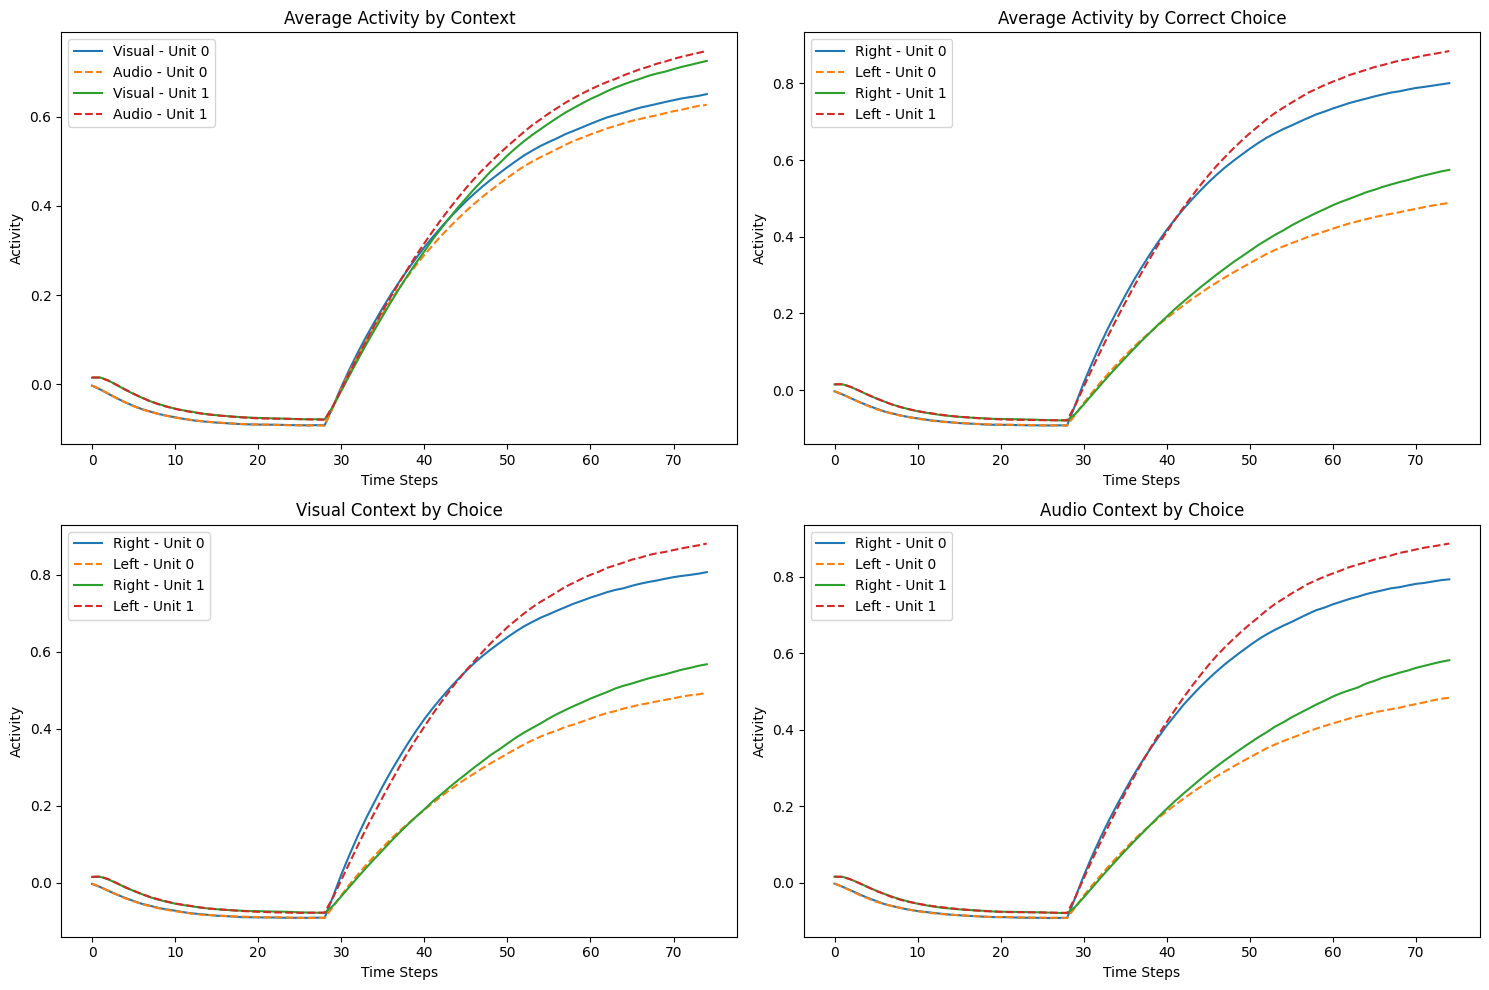

In [8]:
# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions_multi_test = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='multi'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions_multi_test = outputs[:, -1, :]
    correct_choices_multi_test = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions_multi_test], 
                                 device=decisions_multi_test.device)  # Create on same device
    
    predictions_multi_test = (torch.relu(decisions_multi_test[:, 0] - decisions_multi_test[:, 1]) > 0).float()
    accuracy_multi_test = (predictions_multi_test == correct_choices_multi_test).float().mean()
    
    print(f"\nMultisensory Test Accuracy: {accuracy_multi_test.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions_multi_test, outputs_cpu)
    plt.show()

## Test on Unisensory

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0

Post-inference Device Verification:


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\1913581421.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\1913581421.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_18220\1913581421.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)



Unisensory Test Accuracy: 98.80%


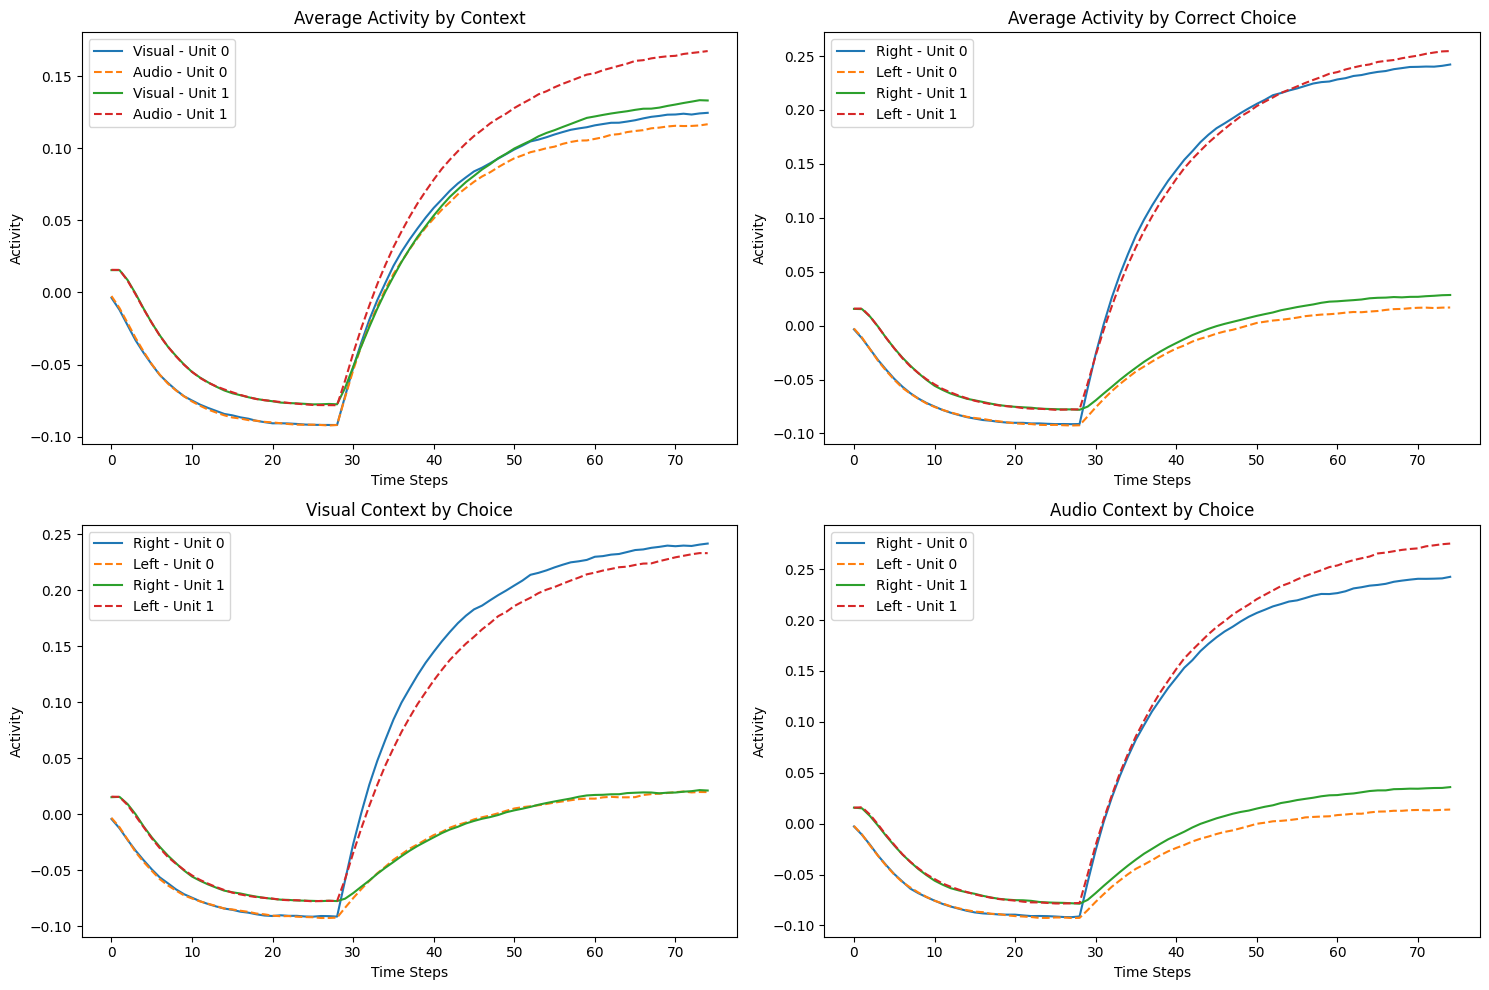

In [9]:
importlib.reload(TMUM)

# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions_uni_test = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='uni'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions_uni_test = outputs[:, -1, :]
    correct_choices_uni_test = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions_uni_test], 
                                 device=decisions_uni_test.device)  # Create on same device
    
    predictions_uni_test = (torch.relu(decisions_uni_test[:, 0] - decisions_uni_test[:, 1]) > 0).float()
    accuracy_uni_test = (predictions_uni_test == correct_choices_uni_test).float().mean()
    
    print(f"\nUnisensory Test Accuracy: {accuracy_uni_test.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions_uni_test, outputs_cpu)
    plt.show()

## Model Weights

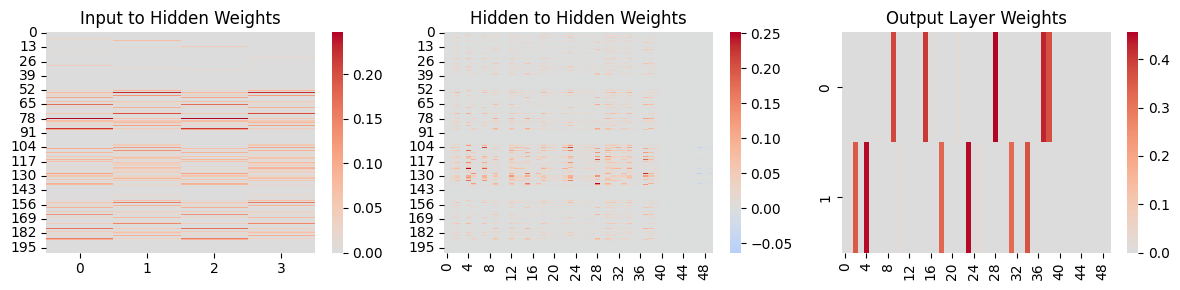

In [10]:
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Input to Hidden weights
weights_ih = net.lstm.weight_ih_l0.data.cpu().detach().numpy()
sns.heatmap(weights_ih, center=0, cmap="coolwarm", ax=axes[0])
axes[0].set_title('Input to Hidden Weights')

# Hidden to Hidden weights
weights_hh = net.lstm.weight_hh_l0.data.cpu().detach().numpy()
sns.heatmap(weights_hh, center=0, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Hidden to Hidden Weights')

# Output weights
output_weights = net.output_layer.weight.data.cpu().detach().numpy()
sns.heatmap(output_weights, center=0, cmap="coolwarm", ax=axes[2])
axes[2].set_title('Output Layer Weights')

# Adjust layout to prevent overlap
plt.tight_layout()

# Optional: Save the figure
plt.savefig('weight_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# New Sections

What we just did is probably not that useful, we need to put model in training model, after having the model trained to 'expert' mode and see how it reacts when the context switches.

Furthermore we can do some cool selectivity measures in multisensory.

## Moving window of model performance

In [6]:
import importlib
import plotting_functions as pf
importlib.reload(pf)

<module 'plotting_functions' from 'c:\\Users\\Runyan1\\Downloads\\RNN\\plotting_functions.py'>

iteration: 0 trials per context: 50
iteration: 1 trials per context: 50
iteration: 2 trials per context: 50
iteration: 3 trials per context: 50
iteration: 4 trials per context: 50
iteration: 5 trials per context: 50
iteration: 6 trials per context: 50
iteration: 7 trials per context: 50
iteration: 8 trials per context: 50
iteration: 9 trials per context: 50
iteration: 10 trials per context: 50
iteration: 11 trials per context: 50
iteration: 12 trials per context: 50
iteration: 13 trials per context: 50
iteration: 14 trials per context: 50
iteration: 15 trials per context: 50
iteration: 16 trials per context: 50
iteration: 17 trials per context: 50
iteration: 18 trials per context: 50
iteration: 19 trials per context: 50
iteration: 20 trials per context: 50
iteration: 21 trials per context: 50
iteration: 22 trials per context: 50
iteration: 23 trials per context: 50
iteration: 24 trials per context: 50
iteration: 25 trials per context: 50
iteration: 26 trials per context: 50
iteration: 

C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17560\2987201619.py:25: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(tpc_values, accuracies_it, vert=True)


Text(0.5, 1.0, 'Accuracy vs Trials per Context')

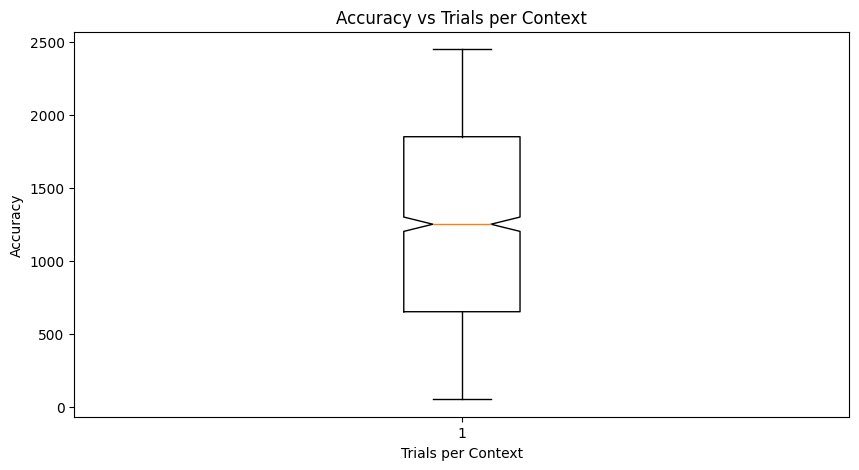

In [ ]:
# trials per context to iterate through
tpc = list(range(50, 2500, 50))
# Initialize lists to store accuracies and switches
accuracies_it = []
tpc_values = []

#run 30 iterations for each trials per context
for trials_per_context in tpc:
    for _ in range(30):

        iteration_accuracies, switches = pf.moving_window(net, trials = 5000, window_size=30,
                                                trials_per_context=trials_per_context,
                                                plotting = False)

        accuracies_it.append(np.mean(iteration_accuracies))
        tpc_values.append(trials_per_context)
        print("iteration:", _, "trials per context:", trials_per_context)



#accuracies, switches = pf.moving_window(net, trials = 5000, window_size=50, trials_per_context=500)
#print(f"Overall Accuracy: {np.mean(accuracies):.2%}")





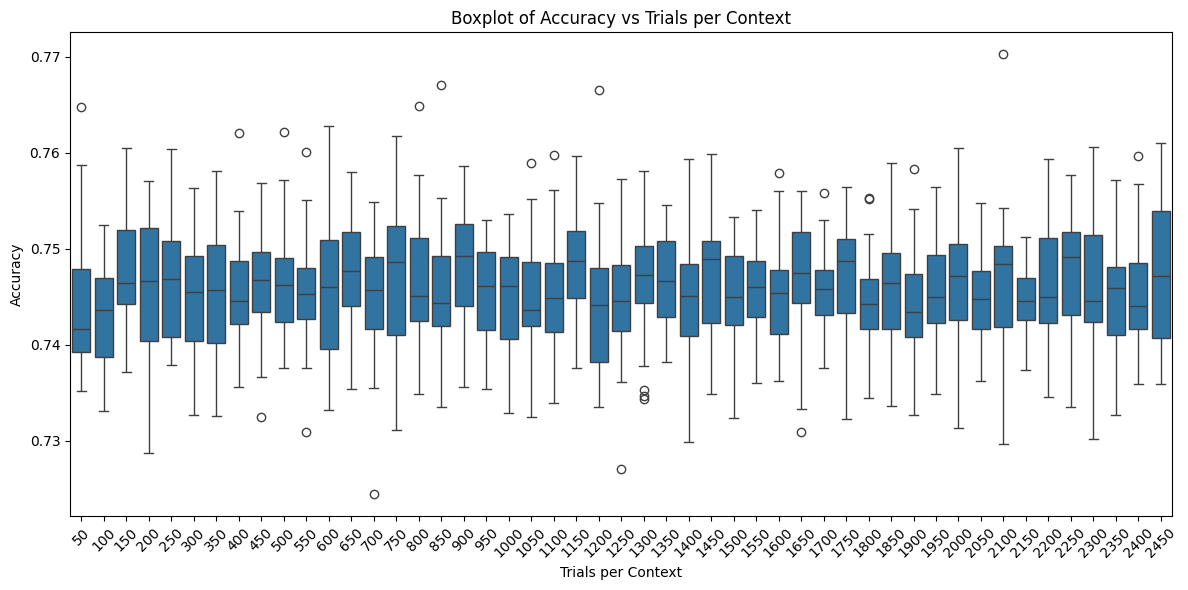

In [ ]:
# Generate a boxplot of trials per context vs accuracy
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame({'Accuracy': accuracies_it, 'Trials per Context': tpc_values})
plt.figure(figsize=(12, 6))
sns.boxplot(x=tpc_values, y=accuracies_it)
plt.xlabel('Trials per Context')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy vs Trials per Context')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Well well well, it appears our model may not be learning context and it just figuring out to guess the highest absolute value direction.

# Are we LSTMing

no not stimming

Running LSTM diagnostics...
Temporal correlation: 0.832
LSTM Gradient Statistics:

weight_ih_l0:
Gradient mean: 2.67e-01
Gradient std: 1.09e+00
Gradient min: -3.11e+00
Gradient max: 4.50e+00

weight_hh_l0:
Gradient mean: 2.20e-02
Gradient std: 1.07e-01
Gradient min: -4.50e-01
Gradient max: 7.04e-01

bias_ih_l0:
Gradient mean: 4.20e-01
Gradient std: 1.87e+00
Gradient min: -4.73e+00
Gradient max: 6.47e+00

bias_hh_l0:
Gradient mean: 4.20e-01
Gradient std: 1.87e+00
Gradient min: -4.73e+00
Gradient max: 6.47e+00


Net_lstm(
  (activation): ReLU()
  (lstm_dropout): Dropout(p=0.2, inplace=False)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(4, 100, batch_first=True)
  (output_layer): Linear(in_features=100, out_features=2, bias=False)
)

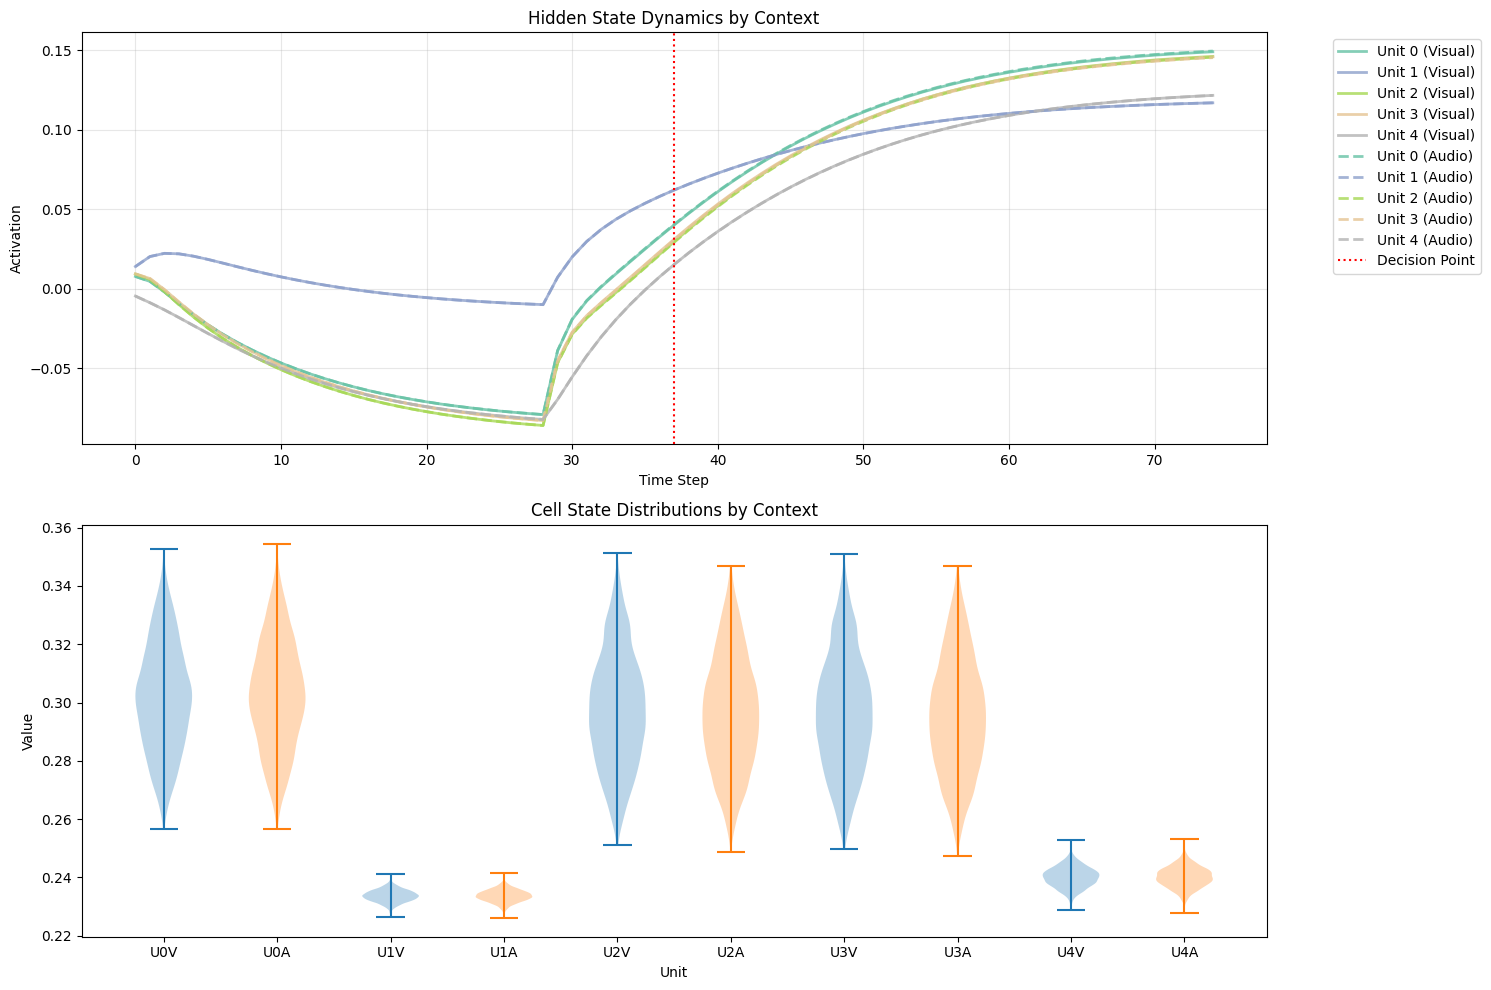

In [10]:
import LSTM_Analysis as LA
importlib.reload(LA)

# After training, run diagnostics
print("Running LSTM diagnostics...")

# Check temporal memory
temporal_corr = LA.test_temporal_memory(net)

# Analyze dynamics on test data
hidden_states, cell_states = LA.analyze_lstm_dynamics(net, u, conditions_train)

# Check gradients during training
net.train()
outputs, _ = net(u)
loss = criterion(outputs, z)
loss.backward()
LA.check_lstm_gradients(net)
net.eval()

## Do neurons change selectivity?